# Introduction to Ensembling/Stacking in Python
---
https://www.kaggle.com/code/arthurtok/introduction-to-ensembling-stacking-in-python/notebook   
캐글 필사 스터디를 진행하면서 기존에 작성된 코드 및 설명을 필사한다.   

## Introduction
이 노트북은 모델들을 앙상블하는 방법에 대한 아주 기본적이고 간단한 입문서이며, 특히 Stacking으로 알려진 다양한 앙상블 기법이다. 간략히 애기하면 Stacking은 **몇 가지 기본적인 분류기의 예측값을 사용한(first-level) 다음 first-level로부터 예측한 값으로 output을 예측하기 위해 다른 모델를 사용한다(second-level).**

Titanic dataset은 캐글을 시작하는 많은 임문자들에게 Stacking의 개념을 도입하기 위한 중요한 후보이다. 게다가 Stacking이 캐글 대회에서 많은 팀들의 우승의 원인이였지만, 이 주제에 대한 커널들이 부족해 보인다. 그래서 이 노트북이 부족한 것들을 채워 주길 바란다.

나 자신도 Kaggle scene에서 꽤 신입이고, 우연히 발견하고 연구하여 처음으로 적절하게 작성한 Ensembling/Stacking script는 Faron이 AllState Severity Claims competition 작성된 것이다. **이 노트북 자료는 Faron의 script를 많이 차용했지만, Faron의 regressor of ensemble를 classifier of ensemble로 변환하였다.** 어쨋든 Faron의 script는 여기서 확인해라.  
- [Stacking Starter](https://www.kaggle.com/code/mmueller/stacking-starter) : by Faron

In [54]:
# Load in our libraries
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

# Going to use these 5 base models for the stacking
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier,
                                GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.model_selection import KFold

## Feature Exploration, Engineering and Cleaning

일반화된 대부분의 커널 방법처럼 진행한다. 첫번째로 데이터를 탐구하고, 가능한 특징 엔지니어링 기회를 식별하고 어떤 범주형 특징들을 수치적으로 인코딩한다.

In [65]:
# Load in the train and test datasets
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

#Store our passenger ID for easy access
PassengerId = test['PassengerId']

train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


우리의 임무는 어떻게든 범주형 변수에서 정보를 추출하는 일이다.

### Feature Engineering

여기서, 특징 엔지니어링 아이디어를 포괄적이고 잘 고안해 놓은 Sina의 노트북을 확인하라.
- [Titanic Best Working Classfier](https://www.kaggle.com/code/sinakhorami/titanic-best-working-classifier) : by Sina

In [66]:
full_data = [train, test]

# <-- Feature Engineering -->
# some features of my own that I have added in
# Gives the length of the name
train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)
# Feature that tells whether a passenger had a cabin on the Titanic
train['has_Cabin'] = train['Cabin'].apply(lambda x: 0 if type(x) == float else 1)
test['has_Cabin'] = test['Cabin'].apply(lambda x: 0 if type(x) == float else 1)

# Feature engineering steps taken from Sina
# Create new feature FamilySize as a combination of SibSp and Parch
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
# Create new feature IsAlone From Family Size
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
# Remove all NULLS in the Embarked column
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
# Remove all NULLS in the Fare column and create a new feature CategoricalFare
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)
# Create a New feature CategoricalAge
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
train['CategoricalAge'] = pd.cut(train['Age'], 5)
# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it
    if title_search:
        return title_search.group(1)
    return ""
# Create a new feature Title, containing the titles fo passenger names
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
# Group all non-common titles into one single grouping "Rare"
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    
# <-- Data Cleaning -->
for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    # Mapping titles
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare' ] = 0
    dataset.loc[ (dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare' ] = 1
    dataset.loc[ (dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare' ] = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare' ] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age' ] = 0
    dataset.loc[ (dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age' ] = 1
    dataset.loc[ (dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age' ] = 2
    dataset.loc[ (dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age' ] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age' ] = 4

In [67]:
# Feature selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
test = test.drop(drop_elements, axis = 1)

feature engineering, cleaning, drop categorical columns를 수행하면 모든 feature들은 숫자여야 하며 Machine Learning models에 먹이기에 적합한 포맷이어야 한다. 하지만 우리는 진행하기 이전에 변환된 데이터셋의 간단한 상관관계와 분포를 확인하겠다.
## Visualisations

In [68]:
train.head(3)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,23,0,2,0,1
1,1,1,0,2,0,3,1,51,1,2,0,3
2,1,3,0,1,0,1,0,22,0,1,1,2


### Pearson Correlation Heatmap
하나의 특성이 다른 특성들과 얼마나 관련있느지 확인하기 위해 특징들의 상관관계를 그린다. 그렇게 하기위해, 우리는 heatmap을 펼리하게 그릴 수 있는 Seaborn plotting 패키지를 활용 할 것이다.

<AxesSubplot:title={'center':'Person Correlation of Features'}>

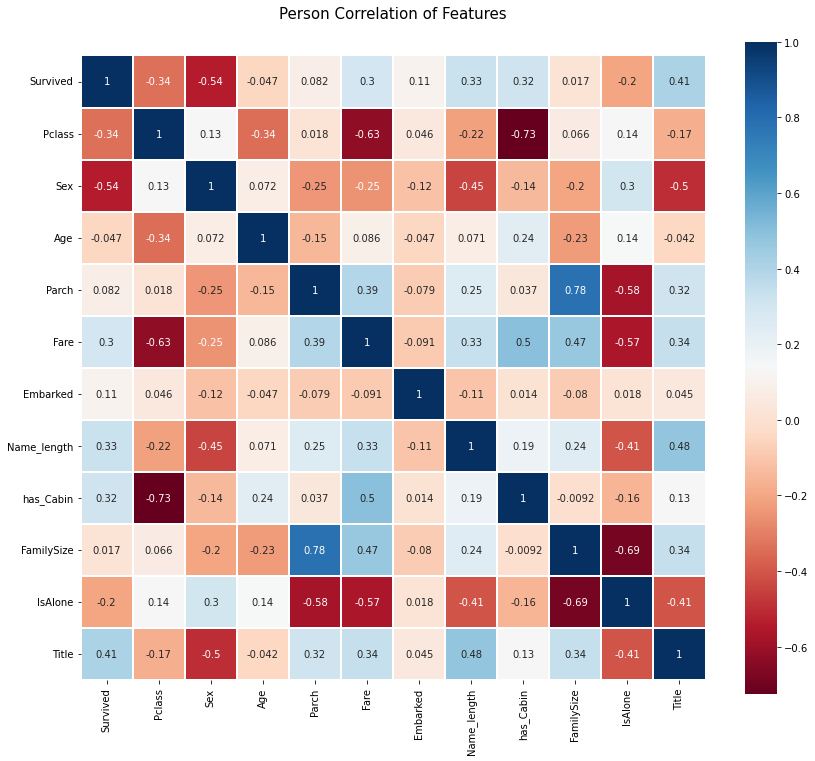

In [69]:
colormap = plt.cm.RdBu # colormap config
plt.figure(figsize=(14,12))
plt.title('Person Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(), linewidths=0.1, vmax=1.0,
            square=True, cmap=colormap, linecolor='white', annot=True)

### Takeaway from the Plots
Pearson Correlation plot를 보면 알 수 있는 사실은 서로 강하게 상관되는 많은 feature가 없다는 것이다. 이것은 train 데이터에 중복되거나 불필요한 데이터가 많지 않다는 것을 의미하고 각 특징에 고유한 정보가 포함되어 있다는 것이기 때문에 학습 모델에 특징을 제공하는 관점에서 좋다. 여기서 가장 상관관계가 큰 두 개의 특징은 Family size와 Parch 이다. 훈련의 목적을 위해 두 개의 특징을 그대로 둘 것이다.

### Pairplots
하나의 특징이 다른 것들에 데이터 분포를 관측하기 위해 pairplot를 사용한다.